### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import Counter
from networkx.linalg.graphmatrix import adjacency_matrix

### Verifying raw data path
If assertion fails, download the movielens-100k ratings data from [konect](http://konect.cc/networks/movielens-100k_rating/) and put the files in data/raw.

In [2]:
raw_data_path ="data/raw/"
figure_path = "data/figures/"
bipartite_path = "data/bipartite/full_bipartite.p"
projection_path = "data/projections/"

assert os.path.exists(raw_data_path)

### Create/load the bipartite network

In [3]:
if os.path.exists(bipartite_path):
    with open(bipartite_path, 'rb') as f:
        G = pickle.load(f)
    print("Graph loaded")
else:
    G = nx.Graph()
    
    with open(raw_data_path+"rel.rating.csv", 'r') as f:
        movie_ids = set()
        user_ids = set()
        edges = []
        for line in f.readlines():
            userid, movieid, rating, timestamp = tuple(map(int, line.strip().split(' ')))
            movie_ids.add(movieid)
            userid += 10000
            user_ids.add(userid)
            edges.append((userid, movieid, rating))  # Discarding the timestamp attribute of edges

    G.add_nodes_from(user_ids, bipartite=0)
    G.add_nodes_from(movie_ids, bipartite=1)
    G.add_weighted_edges_from(edges)

    with open(bipartite_path, 'wb') as f:
        pickle.dump(G, f)
    print("Graph created and saved")

Graph loaded


These are summary statistics of the graph from running scripts/metrics.py (removed irrellevant statistics):

#### Basic Statistics
Number of Nodes: 2625, Number of Edges: 100000, Global Density: 0.029, Global Diameter: 5 

####  Degree Statistics
Average Degree: 76.19, Five-Number-Summary Degrees: [  1.,  15.,  42., 106., 737.]

#### Connected Components Statistics
Number of CC: 1, Average CC Size: 2625.0, Average CC Density: 0.029036004645760744}, 

### Weight (Rating) Distribution

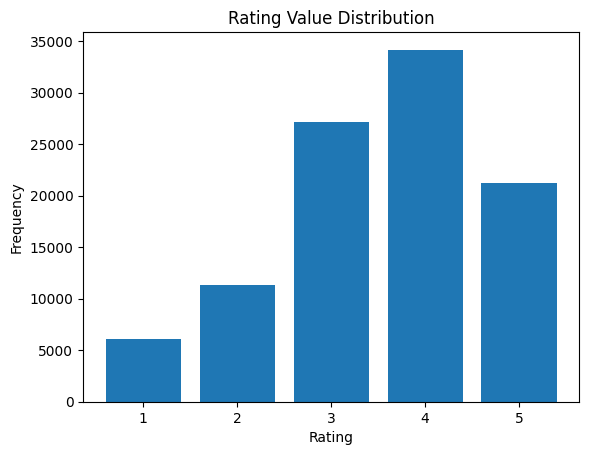

In [4]:
weights = list(edge[2]['weight'] for edge in G.edges(data=True))
unique, count = np.unique(weights, return_counts=True)
plt.bar(unique, count)
plt.title("Rating Value Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency");
np.mean(weights), np.std(weights)
plt.savefig(figure_path+"bipartite_rating_value_distribution.png")

### Degree Distribution

In [5]:
def plot_ccdf(degree_dictionary):  # takes dict(G.degree)
   dd = Counter(degree_dictionary.values())
   dd = pd.DataFrame(list(dd.items()), columns = ("degree", "count")).sort_values(by = "degree")
   ccdf = dd.sort_values(by = "degree", ascending = False)
   ccdf["cumsum"] = ccdf["count"].cumsum()
   ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
   ccdf = ccdf[["degree", "ccdf"]].sort_values(by = "degree")
   return ccdf

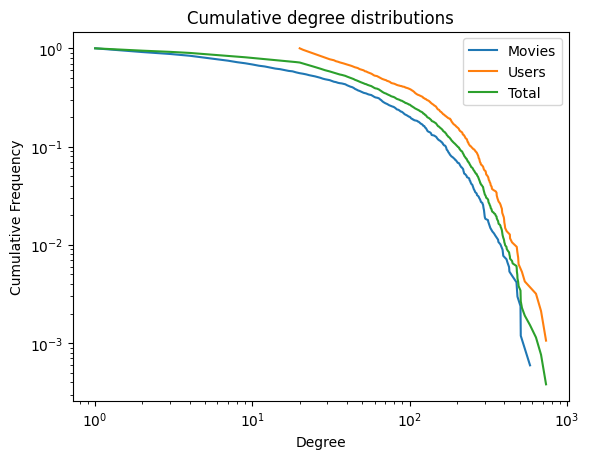

In [6]:
movie_degrees = {k:v for k,v in dict(G.degree()).items() if k < 10000}
user_degrees = {k:v for k,v in dict(G.degree()).items() if k >= 10000}

movie_ccdf = plot_ccdf(movie_degrees)
user_ccdf = plot_ccdf(user_degrees)
total_ccdf = plot_ccdf(dict(G.degree()))

ax = plt.gca()
                       
movie_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Movies', ax=ax)
user_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Users', ax=ax);
total_ccdf.plot(kind='line', x='degree', y='ccdf', loglog=True, label='Total', ax=ax);

ax.set_title("Cumulative degree distributions")                       
plt.ylabel("Cumulative Frequency")
plt.xlabel("Degree")
                       
plt.savefig(figure_path+"bipartite_ccdf_movies_and_users.png")

In [7]:
min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'])

C:\Users\45911\AppData\Local\Temp\ipykernel_24784\1373237299.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  min(user_degrees.values()), min(movie_degrees.values()), float(1-movie_ccdf[movie_ccdf['degree'] == 20]['ccdf'])


(20, 1, 0.4417360285374554)

The distributions are not power law; they are shifted and there is exponential cutoff. 20 is the obvious minumum of movies rated by any user, since users with fewer than 20 ratings were discarded when making the data set. Some movies on the other hand have very few ratings, the minimum being 1. 44% of movies are rated by 20 or less people.

Add for next time:
add degree distribution plots
summary statistics 
check for power low

### Generate weighted projection and get the degree centrality of both users and movies

In [8]:
# Split the graph into 2 sets: user and movie nodes
user_nodes, movie_nodes = nx.algorithms.bipartite.basic.sets(G)

# Generate the weighted projections
weighted_projection_users = bipartite.weighted_projected_graph(G, user_nodes)
weighted_projection_movie = bipartite.weighted_projected_graph(G, movie_nodes)

print(weighted_projection_users)
print(weighted_projection_movie)


Graph with 943 nodes and 429110 edges
Graph with 1682 nodes and 983206 edges


In [9]:
# Save the user projection
with open(projection_path +"user_simple_weights_projection.p", 'wb') as f:
    pickle.dump(weighted_projection_users, f)

with open(projection_path +"user_simple_weights_projection.csv", 'wb') as f:
    nx.write_weighted_edgelist(weighted_projection_users,delimiter = ',', path= f)  




In [10]:
# Save the movie projection
with open(projection_path +"movie_simple_weights_projection.p", 'wb') as f:
    pickle.dump(weighted_projection_movie, f)
with open(projection_path +"movie_simple_weights_projection.csv", 'wb') as f:
    nx.write_weighted_edgelist(weighted_projection_movie,delimiter = ',', path= f) 

 Calculate the degree centrality of each user (why are they so high?!) (How many movies each user has rated)

In [11]:
# How many movies each user has rated
# Compute degree centrality for the users projection
users_degree_centrality = nx.degree_centrality(weighted_projection_users)

# Print the degree centrality for each node in the users projection
print("Degree centrality for users:")
for node, centrality in users_degree_centrality.items():
    print(f"Node {node}: {centrality}")


Degree centrality for users:
Node 10240: 0.9235668789808917
Node 10241: 0.9256900212314225
Node 10242: 0.9256900212314225
Node 10243: 0.9734607218683652
Node 10244: 0.9978768577494692
Node 10245: 0.935244161358811
Node 10246: 0.9851380042462845
Node 10247: 0.994692144373673
Node 10248: 0.9734607218683652
Node 10249: 0.9989384288747346
Node 10250: 1.0
Node 10251: 0.9989384288747346
Node 10252: 0.9670912951167728
Node 10253: 0.9978768577494692
Node 10254: 0.9978768577494692
Node 10255: 0.9830148619957537
Node 10256: 0.9957537154989384
Node 10257: 0.9978768577494692
Node 10258: 0.9341825902335457
Node 10259: 0.9989384288747346
Node 10260: 0.881104033970276
Node 10261: 0.9267515923566879
Node 10262: 0.9989384288747346
Node 10263: 1.0
Node 10264: 0.9968152866242038
Node 10265: 0.9872611464968153
Node 10266: 0.9554140127388535
Node 10267: 0.9564755838641189
Node 10268: 1.0
Node 10269: 0.9798301486199575
Node 10270: 1.0
Node 10271: 1.0
Node 10272: 0.9150743099787686
Node 10273: 0.846072186836

Calculate the degree centrality of each movie (why are they so high?!) (How many ratings per movie)

In [12]:
# Compute degree centrality for the movie projection
movie_degree_centrality = nx.degree_centrality(weighted_projection_movie)

# Print the degree centrality for each node in the movie projection
print("Degree centrality for movies:")
for node, centrality in movie_degree_centrality.items():
    print(f"Node {node}: {centrality}")

Degree centrality for movies:
Node 1: 0.9476502082093992
Node 2: 0.9238548483045806
Node 3: 0.8399762046400953
Node 4: 0.9440809042236764
Node 5: 0.9066032123735872
Node 6: 0.7495538370017847
Node 7: 0.943486020226056
Node 8: 0.942296252230815
Node 9: 0.9381320642474718
Node 10: 0.8661511005353957
Node 11: 0.9440809042236764
Node 12: 0.9553837001784653
Node 13: 0.925639500297442
Node 14: 0.908982748364069
Node 15: 0.9149315883402737
Node 16: 0.7870315288518739
Node 17: 0.8215348007138609
Node 18: 0.6882807852468769
Node 19: 0.7906008328375967
Node 20: 0.8483045806067817
Node 21: 0.901249256395003
Node 22: 0.952409280190363
Node 23: 0.93575252825699
Node 24: 0.9143367043426532
Node 25: 0.9339678762641286
Node 26: 0.8792385484830458
Node 27: 0.8947055324211779
Node 28: 0.9476502082093992
Node 29: 0.8798334324806664
Node 30: 0.8720999405116002
Node 31: 0.9208804283164783
Node 32: 0.9125520523497919
Node 33: 0.8726948245092208
Node 34: 0.5193337299226651
Node 35: 0.669244497323022
Node 36:

The most infuelncial user (max degree centrality), movie popularity (max degree centrality)

In [13]:
# Find the user with the highest degree centrality
most_influential_user = max(users_degree_centrality , key=users_degree_centrality .get)
centrality_value_user = users_degree_centrality [most_influential_user]

# Add the 1000 to user ID
most_influential_user += 10240

print(f"The most influential user is {most_influential_user} with degree centrality {centrality_value_user}")


# Find the movie with the highest degree centrality
most_rated_movie = max(movie_degree_centrality, key=movie_degree_centrality.get)
centrality_value_movie = movie_degree_centrality[most_rated_movie]

print(f"The most rated movie is {most_rated_movie} with degree centrality {centrality_value_movie}")



The most influential user is 20490 with degree centrality 1.0
The most rated movie is 288 with degree centrality 0.9886972040452112


<function matplotlib.pyplot.show(close=None, block=None)>

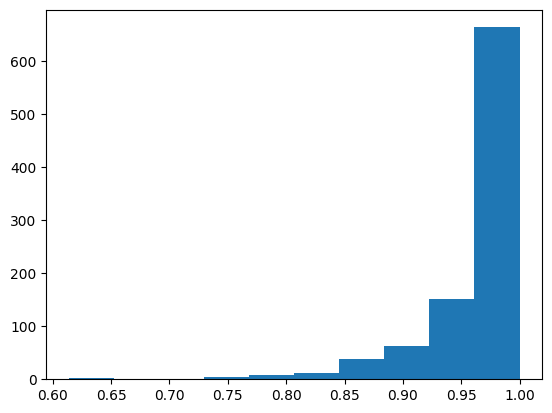

In [14]:
# Distribution of 
plt.hist(users_degree_centrality.values())
plt.show